In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\chuaz\Downloads\LSTM\LSTM\Stock\BB_2021.csv')

In [170]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'bb', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

There are 14215 nulls in sentiment column.
Dropping nulls.


,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_0D_pctchg,comments_positive_0D_pctchg,comment_count_0D_pctchg,pct_pos_comments_0D_pctchg,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,2.0,1.0,3.0,33.332222,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,2.0,1.0,3.0,33.332222,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,3.0,0.0,3.0,0.000000,0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.299964,0,0.262337
4,2021-01-05,0.0,1.0,1.0,99.990001,0,NaN,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.220911,1,-1.509996


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_0D_pctchg     317 non-null    float64       
 7   comments_positive_0D_pctchg    282 non-null    float64       
 8   comment_count_0D_pctchg        321 non-null    float64       
 9   pct_pos_comments_0D_pctchg     282 non-null    float64       
 10  comments_neutral_1D_pctchg     338 non-null    float64       
 11  comments_positive_1

In [171]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Daily%Change', 'SD', '6D%Change', '2Dir', '4D%Change', 'Volume', 'Open', '2D%Change', '5Dir', '5D%Change', '7Dir', 'High', '4Dir', '6Dir', '3D%Change', 'Low', '3Dir', 'Dir', 'SD_log']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


## LSTM: BB Close Price

In [6]:
#https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-multivariate-prediction-models

### Original

In [7]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close(t-1)']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.25
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.41
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.48
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.40
249,9.21,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,9.44


In [8]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close(t-1)'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(243, 23)


In [9]:
data_filtered_ext

,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35,12.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.25
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.41
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.48
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.40


In [10]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close(t-1)")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.37372592205278654
0.37372592205278654


In [11]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/10
12/12 [==============================] - 1s 107ms/step - loss: 0.0144 - val_loss: 0.0027
Epoch 2/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 0.0020
Epoch 3/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0016
Epoch 4/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0098 - val_loss: 0.0029
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 6/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 7/10
12/12 [==============================] - 0s 12ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 8/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 9/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 10/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0073 - val_loss: 0.0021


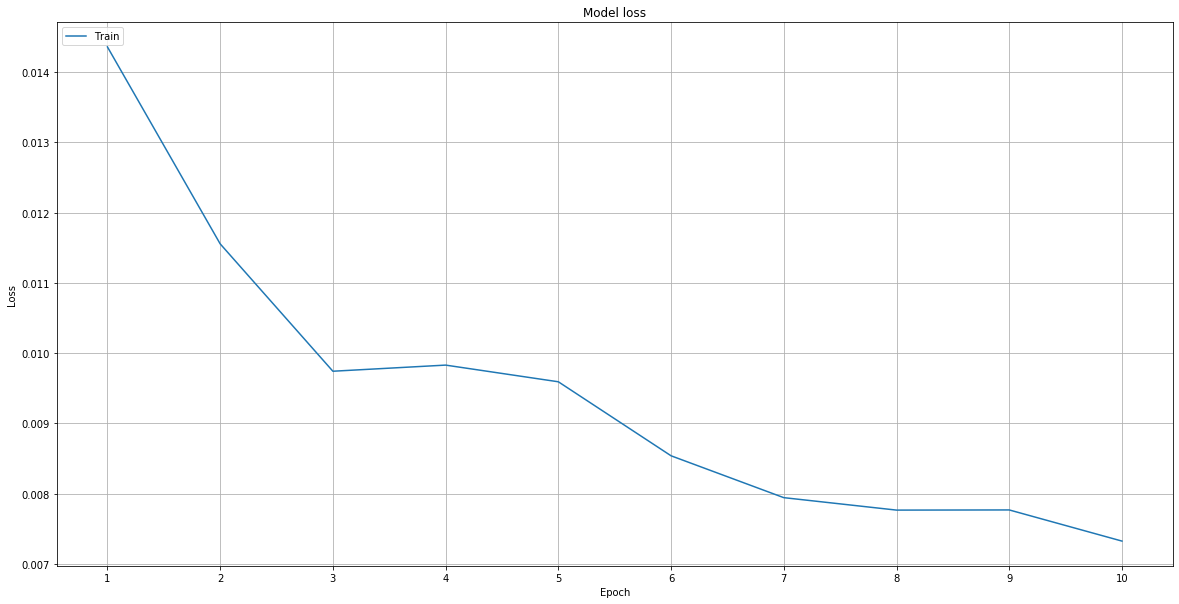

In [13]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [14]:
#recompile with epochs = 7
epochs = 7
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/7
12/12 [==============================] - 0s 20ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 2/7
12/12 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0016
Epoch 3/7
12/12 [==============================] - 0s 16ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 4/7
12/12 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 5/7
12/12 [==============================] - 0s 16ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 6/7
12/12 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 7/7
12/12 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.0013


In [15]:
from sklearn.metrics import mean_absolute_error

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
y_pred_scaled = model.predict(x_test)

for i in range(7):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled[:,i,:])
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    MAE_list.append(MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    MAPE_list.append(MAPE)

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.63
Mean Absolute Percentage Error (MAPE): 6.34 %
Median Absolute Percentage Error (MDAPE): 6.23 %
Median Absolute Error (MAE): 0.68
Mean Absolute Percentage Error (MAPE): 7.05 %
Median Absolute Percentage Error (MDAPE): 6.22 %
Median Absolute Error (MAE): 0.57
Mean Absolute Percentage Error (MAPE): 5.8 %
Median Absolute Percentage Error (MDAPE): 5.05 %
Median Absolute Error (MAE): 0.46
Mean Absolute Percentage Error (MAPE): 4.66 %
Median Absolute Percentage Error (MDAPE): 4.08 %
Median Absolute Error (MAE): 0.48
Mean Absolute Percentage Error (MAPE): 4.75 %
Median Absolute Percentage Error (MDAPE): 4.14 %
Median Absolute Error (MAE): 0.42
Mean Absolute Percentage Error (MAPE): 4.13 %
Median Absolute Percentage Error (MDAPE): 3.81 %
Median Absolute Error (MAE): 0.33
Mean Absolute Percentage Error (MAPE): 3.26 %
Median Absolute Percentage Error (MDAPE): 2.54 %


,MAE,MAPE,MDAPE
0,0.629102,6.339459,6.228377
1,0.684901,7.047897,6.223595
2,0.568785,5.803508,5.051016
3,0.464882,4.662218,4.082229
4,0.481105,4.751079,4.142004
5,0.420707,4.133837,3.808971
6,0.326798,3.257584,2.537531


In [16]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close(t-1)"], True)

In [17]:
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

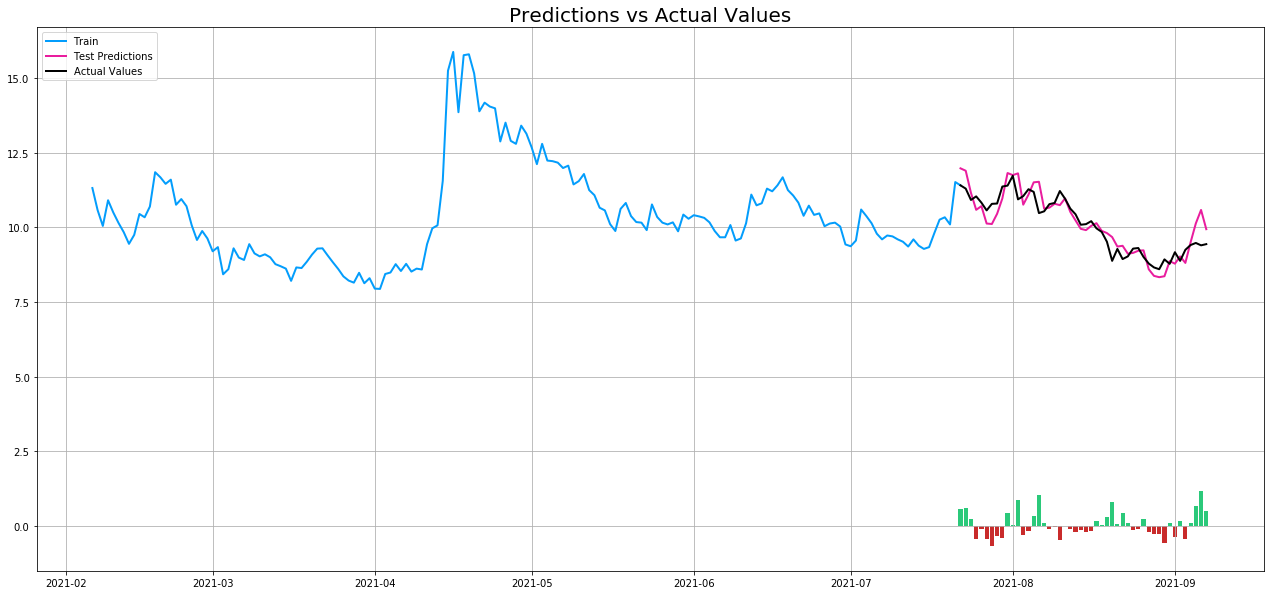

In [18]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close(t-1)"]]
xv = valid['Date']; yv = valid[["Close(t-1)", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close(t-1)"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Early stopping, Model Check Point and No data Leakage

In [208]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Daily%Change', 'SD', '6D%Change', '2Dir', '4D%Change', 'Volume', 'Open', '2D%Change', '5Dir', '5D%Change', '7Dir', 'High', '4Dir', '6Dir', '3D%Change', 'Low', '3Dir', 'Dir', 'SD_log']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [209]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.41
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.48
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.40
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.44
249,9.21,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,9.21


In [210]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [211]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.5996602737817465
0.5996602737817465


In [212]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [213]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'closeprice_bb_nosen.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0262
Epoch 00001: val_loss improved from inf to 0.00375, saving model to closeprice_bb_nosen.h5
12/12 [==============================] - 1s 71ms/step - loss: 0.0212 - val_loss: 0.0038
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0069
Epoch 00002: val_loss did not improve from 0.00375
12/12 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0041
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0081
Epoch 00003: val_loss did not improve from 0.00375
12/12 [==============================] - 0s 17ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0077
Epoch 00004: val_loss improved from 0.00375 to 0.00303, saving model to closeprice_bb_nosen.h5
12/12 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0030
Epoch 5/100
11/12 [==========================>...] - ETA

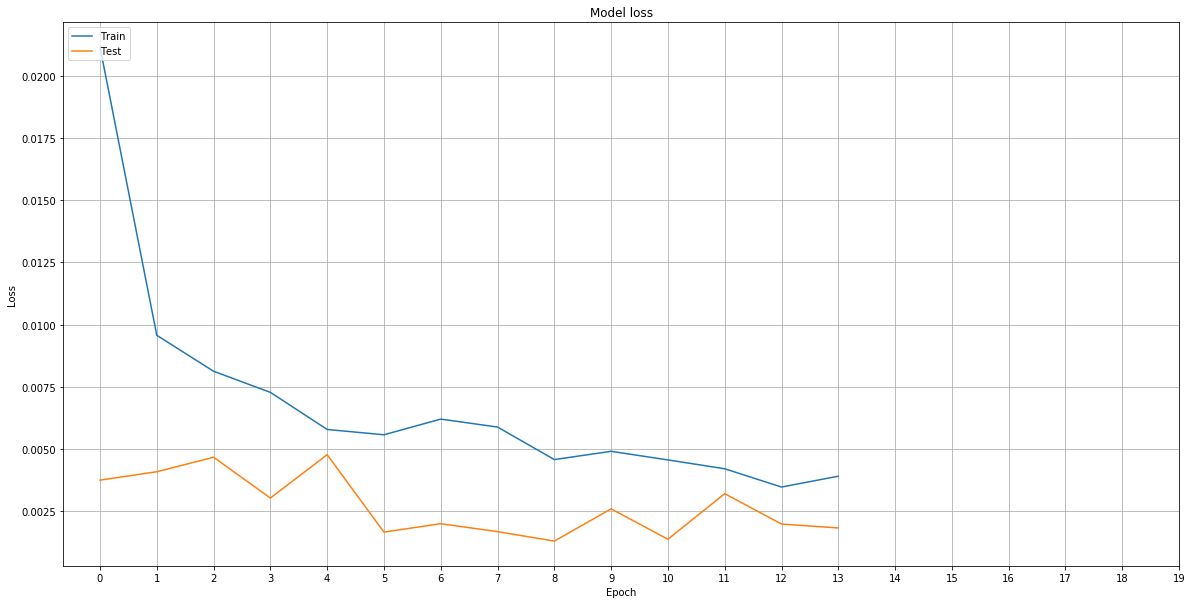

In [214]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [215]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# for i in range(7):
    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.54
Mean Absolute Percentage Error (MAPE): 5.46 %
Median Absolute Percentage Error (MDAPE): 4.68 %


,MAE,MAPE,MDAPE
0,0.542178,5.455703,4.677566


In [216]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

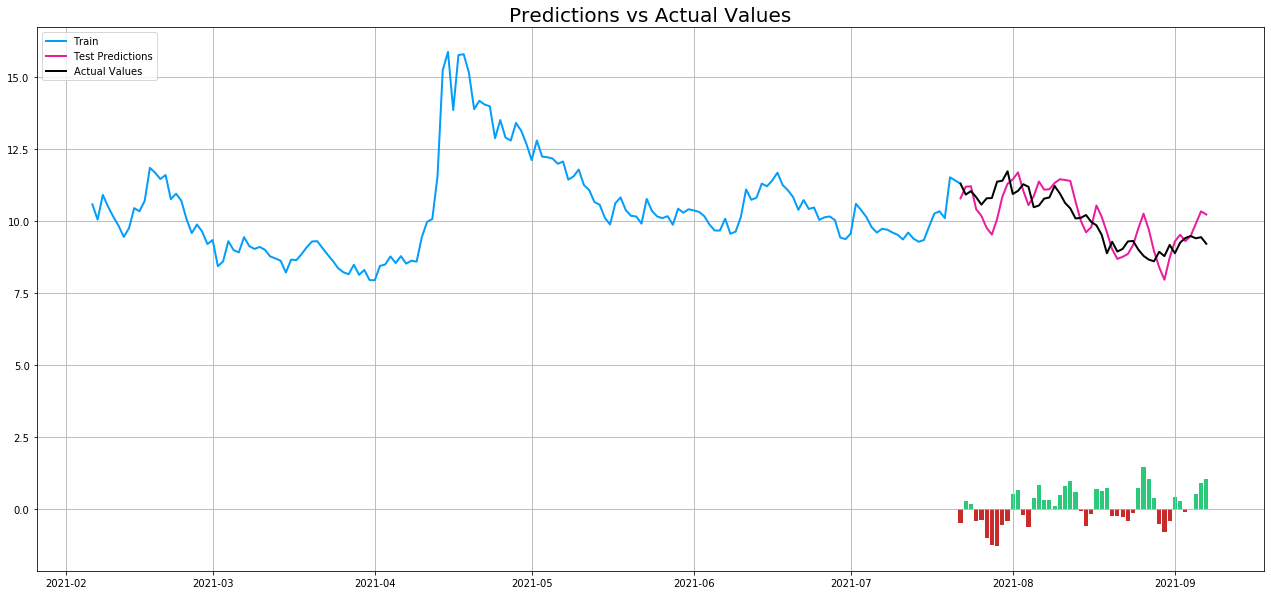

In [217]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Include standard scaler first

In [218]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Daily%Change', 'SD', '6D%Change', '2Dir', '4D%Change', 'Volume', 'Open', '2D%Change', '5Dir', '5D%Change', '7Dir', 'High', '4Dir', '6Dir', '3D%Change', 'Low', '3Dir', 'Dir', 'SD_log']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [219]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.41
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.48
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.40
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.44
249,9.21,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,9.21


In [220]:
data_filtered

,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.872409,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,5.968465,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,2.486482,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.106272,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40


In [221]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

train_copy = train_data

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
################# ELLLYN PLEASE TAKE NOTE HERE, IS IT CLOSE OR CLOSE (T-1)?############################
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [222]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# train_copy = train_data

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
################# ELLLYN PLEASE TAKE NOTE HERE, IS IT CLOSE OR CLOSE (T-1)?############################
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)

# data_filtered

(195, 23)
(55, 23)


In [223]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.5996602737817465
0.5996602737817465


In [224]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [225]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'closeprice_bb_nosen_ss.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00935, saving model to closeprice_bb_nosen_ss.h5
12/12 [==============================] - 1s 62ms/step - loss: 0.0211 - val_loss: 0.0093
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 00002: val_loss improved from 0.00935 to 0.00235, saving model to closeprice_bb_nosen_ss.h5
12/12 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0024
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0088
Epoch 00003: val_loss improved from 0.00235 to 0.00214, saving model to closeprice_bb_nosen_ss.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00004: val_loss improved from 0.00214 to 0.00192, saving model to closeprice_bb_nosen_ss.h5
12/12 [==============================] - 0s 

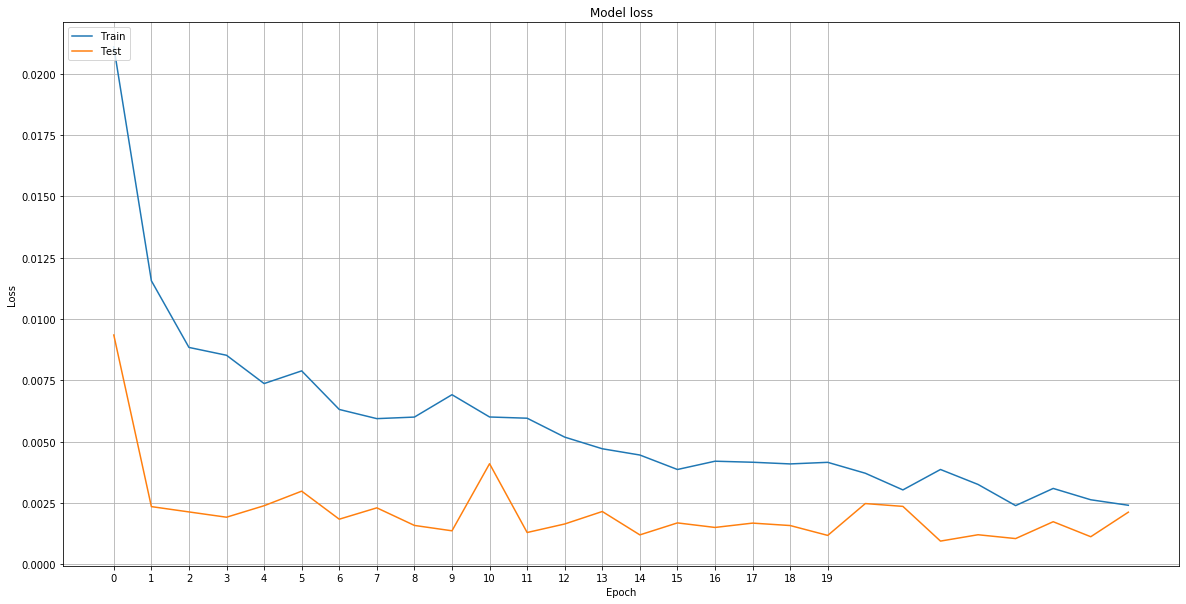

In [226]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [227]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.42
Mean Absolute Percentage Error (MAPE): 4.1 %
Median Absolute Percentage Error (MDAPE): 3.2 %


,MAE,MAPE,MDAPE
0,0.415839,4.103759,3.19687


In [228]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close(t-1)"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

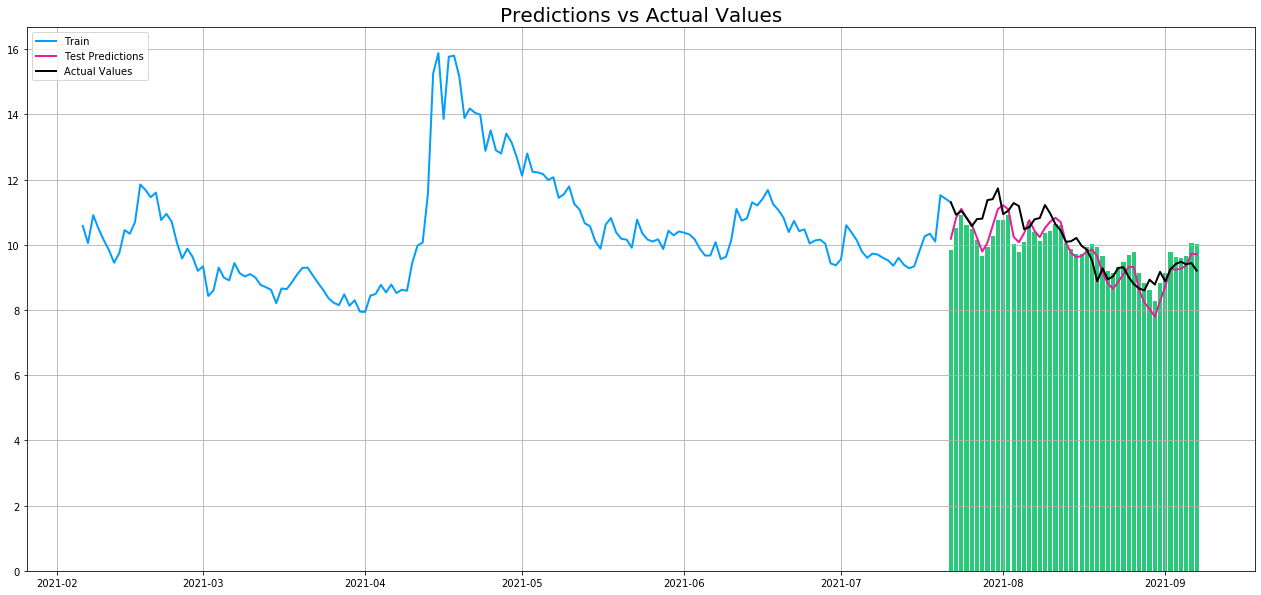

In [229]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: BB Daily%Change

In [19]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '3Dir', 'Volume', 'High', '4Dir', 'Close', '7Dir', '2Dir', 'SD', '7D%Change', 'Open', '5Dir', '3D%Change', '5D%Change', '4D%Change', '2D%Change', 'Dir', 'SD_log', '6Dir', 'Low']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-2.490171,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,22.446231,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,8.013178,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,25.508132,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.562750,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [20]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change(t-1)']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,1.729728,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,4.166665
246,0.743886,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,1.729728
247,-0.843881,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,0.743886
248,0.425532,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,-0.843881
249,-2.436436,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,0.425532


In [21]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(243, 23)


In [22]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9428641473404276
0.9428641473404276


In [23]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/10
12/12 [==============================] - 2s 52ms/step - loss: 0.1451 - val_loss: 0.0531
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0462 - val_loss: 0.0269
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0277 - val_loss: 0.0152
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0080
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0149 - val_loss: 0.0068
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0138 - val_loss: 0.0056
Epoch 7/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0128 - val_loss: 0.0051
Epoch 8/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0125 - val_loss: 0.0051
Epoch 9/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0120 - val_loss: 0.0047
Epoch 10/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0041


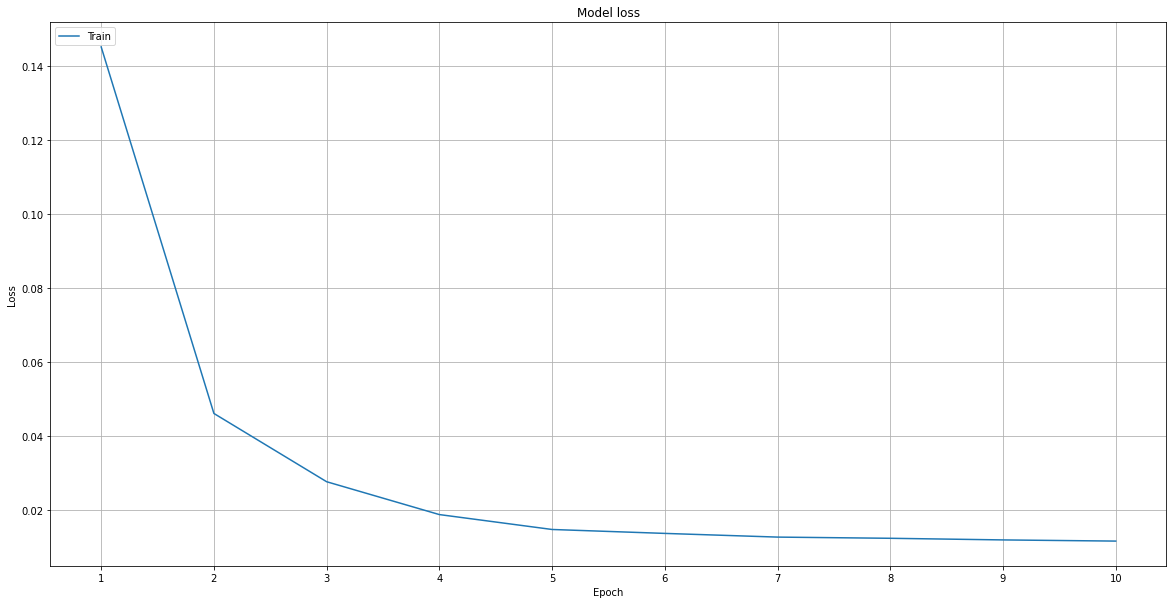

In [25]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [26]:
#recompile with epochs = 9
epochs = 9
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/9
12/12 [==============================] - 0s 12ms/step - loss: 0.0111 - val_loss: 0.0037
Epoch 2/9
12/12 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0036
Epoch 3/9
12/12 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.0028
Epoch 4/9
12/12 [==============================] - 0s 10ms/step - loss: 0.0100 - val_loss: 0.0032
Epoch 5/9
12/12 [==============================] - 0s 9ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 6/9
12/12 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0023
Epoch 7/9
12/12 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0029
Epoch 8/9
12/12 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 9/9
12/12 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0020


In [27]:
from sklearn.metrics import mean_absolute_error

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
y_pred_scaled = model.predict(x_test)

for i in range(7):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled[:,i,:])
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    MAE_list.append(MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    MAPE_list.append(MAPE)

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 3.3
Mean Absolute Percentage Error (MAPE): 299.7 %
Median Absolute Percentage Error (MDAPE): 178.45 %
Median Absolute Error (MAE): 2.89
Mean Absolute Percentage Error (MAPE): 207.6 %
Median Absolute Percentage Error (MDAPE): 129.04 %
Median Absolute Error (MAE): 2.69
Mean Absolute Percentage Error (MAPE): 154.18 %
Median Absolute Percentage Error (MDAPE): 112.57 %
Median Absolute Error (MAE): 2.39
Mean Absolute Percentage Error (MAPE): 109.97 %
Median Absolute Percentage Error (MDAPE): 106.79 %
Median Absolute Error (MAE): 2.48
Mean Absolute Percentage Error (MAPE): 122.55 %
Median Absolute Percentage Error (MDAPE): 107.52 %
Median Absolute Error (MAE): 2.48
Mean Absolute Percentage Error (MAPE): 159.19 %
Median Absolute Percentage Error (MDAPE): 104.08 %
Median Absolute Error (MAE): 2.74
Mean Absolute Percentage Error (MAPE): 191.44 %
Median Absolute Percentage Error (MDAPE): 110.0 %


,MAE,MAPE,MDAPE
0,3.304071,299.703501,178.448472
1,2.885814,207.604505,129.039174
2,2.693547,154.181720,112.572931
3,2.386050,109.967792,106.792334
4,2.483460,122.545336,107.523088
5,2.481216,159.186563,104.076443
6,2.744334,191.437656,110.004518


In [28]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

In [29]:
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

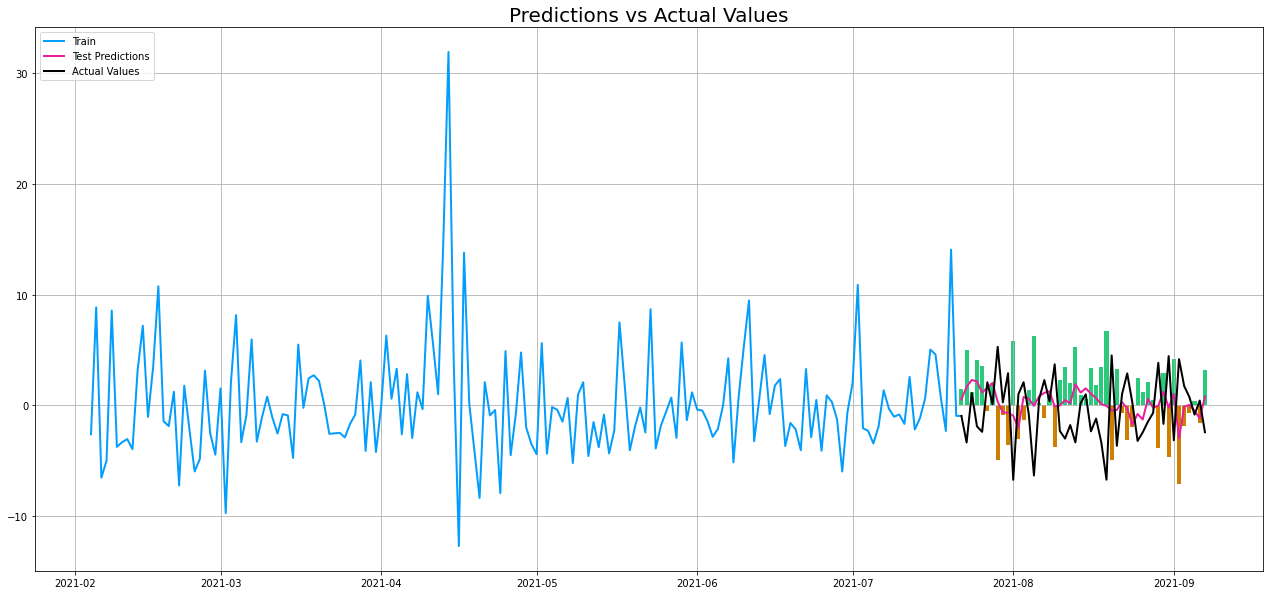

In [30]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: BB SD

In [31]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '3Dir', 'Volume', 'High', '4Dir', 'Close', '2Dir', '7Dir', '7D%Change', 'Open', '5Dir', '3D%Change', '5D%Change', '4D%Change', 'Daily%Change', '2D%Change', 'Dir', 'SD_log', '6Dir', 'Low']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,0.509947,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,4.249764,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,6.872453,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,4.257568,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.521333,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [32]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD(t-1)']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,2.486682,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,1.562885
246,1.265153,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,2.486682
247,0.900125,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,1.265153
248,0.964008,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,0.900125
249,0.663311,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,0.964008


In [33]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD(t-1)'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(243, 23)


In [34]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD(t-1)")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [35]:
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.26390947301658974
0.26390947301658974


In [36]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/10
12/12 [==============================] - 3s 47ms/step - loss: 0.0220 - val_loss: 0.0039
Epoch 2/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0032
Epoch 3/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0169 - val_loss: 0.0037
Epoch 4/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.0013
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0168 - val_loss: 0.0018
Epoch 6/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0174 - val_loss: 0.0056
Epoch 7/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0165 - val_loss: 0.0071
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0164 - val_loss: 0.0027
Epoch 9/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0168 - val_loss: 0.0012
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0041


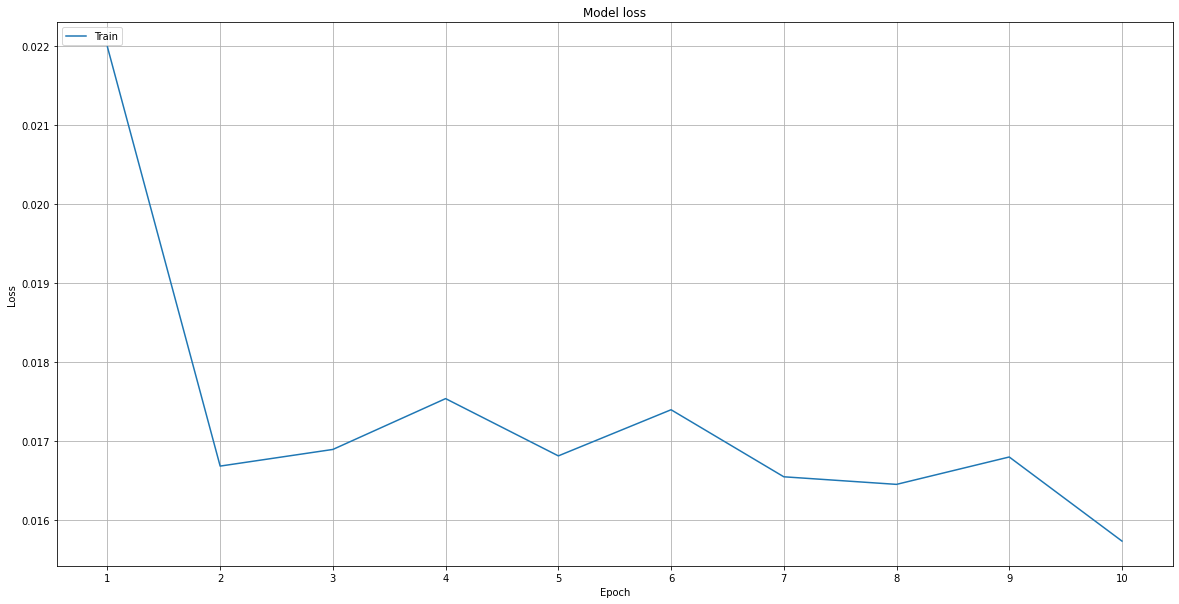

In [38]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [39]:
#recompile with epochs = 8
epochs = 8
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop]
                   )

Epoch 1/8
12/12 [==============================] - 0s 13ms/step - loss: 0.0158 - val_loss: 0.0039
Epoch 2/8
12/12 [==============================] - 0s 11ms/step - loss: 0.0155 - val_loss: 0.0018
Epoch 3/8
12/12 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0014
Epoch 4/8
12/12 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0057
Epoch 5/8
12/12 [==============================] - 0s 10ms/step - loss: 0.0176 - val_loss: 0.0077
Epoch 6/8
12/12 [==============================] - 0s 11ms/step - loss: 0.0157 - val_loss: 0.0011
Epoch 7/8
12/12 [==============================] - 0s 11ms/step - loss: 0.0158 - val_loss: 0.0043
Epoch 7: early stopping


In [40]:
from sklearn.metrics import mean_absolute_error

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
y_pred_scaled = model.predict(x_test)

for i in range(7):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled[:,i,:])
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    MAE_list.append(MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    MAPE_list.append(MAPE)

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.67
Mean Absolute Percentage Error (MAPE): 88.04 %
Median Absolute Percentage Error (MDAPE): 72.45 %
Median Absolute Error (MAE): 0.9
Mean Absolute Percentage Error (MAPE): 116.74 %
Median Absolute Percentage Error (MDAPE): 91.87 %
Median Absolute Error (MAE): 0.98
Mean Absolute Percentage Error (MAPE): 125.83 %
Median Absolute Percentage Error (MDAPE): 105.84 %
Median Absolute Error (MAE): 1.01
Mean Absolute Percentage Error (MAPE): 128.82 %
Median Absolute Percentage Error (MDAPE): 115.27 %
Median Absolute Error (MAE): 1.02
Mean Absolute Percentage Error (MAPE): 130.2 %
Median Absolute Percentage Error (MDAPE): 119.91 %
Median Absolute Error (MAE): 1.01
Mean Absolute Percentage Error (MAPE): 130.03 %
Median Absolute Percentage Error (MDAPE): 119.33 %
Median Absolute Error (MAE): 1.02
Mean Absolute Percentage Error (MAPE): 130.36 %
Median Absolute Percentage Error (MDAPE): 118.48 %


,MAE,MAPE,MDAPE
0,0.672700,88.036746,72.449216
1,0.901780,116.736442,91.867031
2,0.980916,125.832801,105.841729
3,1.006932,128.823554,115.266882
4,1.016387,130.196628,119.913829
5,1.013990,130.028263,119.325301
6,1.017108,130.356356,118.477794


In [41]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD(t-1)"], True)

In [42]:
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

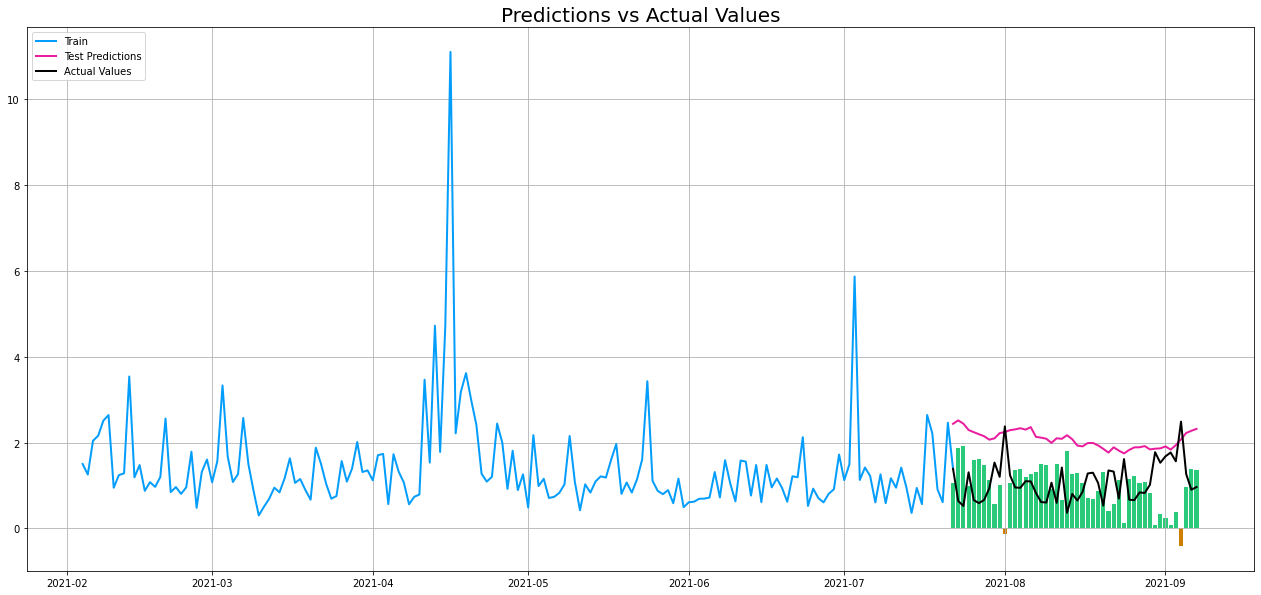

In [43]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD(t-1)"]]
xv = valid['Date']; yv = valid[["SD(t-1)", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD(t-1)"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()